# Quantum Approximate Optimization Algorithm

This program simulates QAOA on Max-Cut problem using qiskit. \
Author: Šimon Mařík \
Note: Ensure you have installed the requirements.txt or environment.yml before running this notebook.

 QAOA is a hybrid quantum-classical algorithm used for solving mainly combinatorical optimization problems. These include quite famous problems like Travelling saleman problem, Knapsack problem or any other optimizing  where the difficulty increases exponentilly. 

In this notebook, I am using QAOA to find solutions of Max-Cut problem. Althought Max-Cut is really simple to understand,  it is NP-complete problem and solutions for more complex inputs are really hard to find. It is set as follow: you have graph with n vertices, and some of them are connected with edges. What is the best way to divide the vertices into two group, so that the numbers of egdges between groups is the highest? In other words, what is the cut that cuts the most edges?

![Max-Cut Example](https://quantum.cloud.ibm.com/assets-docs-learning/_next/image?url=%2Fdocs%2Fimages%2Ftutorials%2Fquantum-approximate-optimization-algorithm%2Fmaxcut-illustration.avif&w=3840&q=75)

Max-Cut Problem might sound abstract, but it has many real world applications. It can be used in microchips designing and manufacturing, in social sciences and statistics (dividing and classifying groups of people), finances and many other. It is also being used as benchmark problem in quantum computing, because it is one of the simplest but difficult cases.

How the algorithm works (overview)?
Firstly, you have to translate the problem into quantum operater called cost Hamiltonian. It evaluetes the better solutions and penalize the worse ones. Then, we aplly mixer Hamiltonian, that mixes the solutions to not be stuck in some local minimum. We can reapet it over and over, with every instance the probable (and hopefully best) solutions becoming even more probable. This is the quantum part. 

The cost and mixer Hamiltonians rotates the qubit by some amount (β, γ), but in the start, we don't know these parametrs. We need to optimize these parameters in order to get the best results. This is being done in classical way, when we run the circuit over and over with changing parametrs to see which performs better. 

Once we find the best-performing parametrs, we run the circuit one more time with these and we get the results. 

The results are not necessary the best ones, but are usually good enough. QAOA can pick up some combinations, that mimic the perfect solution, but it performs worse that the real solution. Hence is important to check more of the top solution, which is again being done by classical algorithm.

#Math behind it
We can transcribe the problem as follows:

$$

\max \sum_{(i,j) \in E} \left( x_i + x_j - 2 x_i x_j \right)

$$
Where $x_i$ means, that vertix i is in group x. ($x \in \{0,1\}$). The expression in sum is pretty clever. If the $x_i$ and $x_j$ are different, it is equall to 1, else it is equal to zero.

$x_i = 0, x_j = 0 : 0 + 0 - 2 \cdot 0 \cdot 0 = 0$

$x_i = 1, x_j = 0 : 1 + 0 - 2 \cdot 1 \cdot 0 = 1$

$x_i = 1, x_j = 0 : 0 + 1 - 2 \cdot 0 \cdot 1 = 1$

$x_i = 1, x_j = 0 : 1 + 1 - 2 \cdot 1 \cdot 1 = 0$

We transcribe this as (because convencions)
$$\min \sum_{(i,j) \in E} \left( 2 x_i x_j - x_i - x_j \right)$$

Then we need to express it in QUBO notation:
$$\min_{x \in \{0,1\}^n} \; Q x$$

In this notation, x is a vector expressing the solution, $ x^T$ is transposed vector of solution and Q is a matrix representing the connections between edges. For triagle it looks like this:
let's say we want to try solution of $x=(1,1,0)$. 
$$
x^T Q x = 
\begin{pmatrix} 1 & 1 & 0 \end{pmatrix}
Q
\begin{pmatrix} 1 \\ 1 \\ 0 \end{pmatrix}

$$

We have to choose carefully matrix Q, in this case it can be 
$$
\begin{pmatrix}
2 & -1 & -1 \\
-1 & 2 & -1 \\
-1 & -1 & -1
\end{pmatrix}
$$
For $x_ii$ it is how many egdes connect to given vertex i and for $x_ij$ if there exists an edge between i and j.

$$
x^T Q x = 
\begin{pmatrix} 1 & 1 & 0 \end{pmatrix}
\begin{pmatrix}
2 & -1 & -1 \\
-1 & 2 & -1 \\
-1 & -1 & -1
\end{pmatrix}
\begin{pmatrix} 1 \\ 1 \\ 0 \end{pmatrix}

$$

In first block of code, I am importing some libraris the code needs. Then we set the graph - edges is list of edges in graph, [x, y] means there exists an edge from vertix x to vertix y. Depth means how many laeyrs the circuit has - more layers = probable results become even more probable. Shots is number of shots used in the simulating. While optimizing the parametrs, it uses only 1/10 of the shots. Variable Seeds means how many times it tries to find best parametrs - to avoid local minima. Checkin is how many best solutions we check by brute force to find the real best solution.

In [1391]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
import random

edges= [
(0,1), (0,2),(0,3), (1,4), (2,5), (3,6), (4,5), (5,6)
#[0, 7], [1, 2], [1, 3], [1, 4], [1, 7], [2, 4], [2, 5], [2, 7], [2, 8], [2, 9], [2, 10], [4, 6], [5, 6], [5, 7], [5, 8], [5, 9], [7, 9], [7, 10]
#(0, 2),(0, 4),(0, 6),(0, 11),(1, 3),(1, 7),(1, 10),(1, 13),(2, 12),(2, 13),(2, 14),(3, 10),(3, 11),(3, 12),(4, 8),(4, 11),(5, 9),(5, 13),(6, 12),(7, 8),(7, 12),(7, 13),(9, 10),(9, 11),(13, 14)
]
#edges is list of edges in graph, [x, y] means there is an edge from vertix x to vertix y
n = 7
#n is number of vertices
depth = 1
shots = 1000
seeds = 1
checkin = 10


There I define my functions - to funcion max_cut_value you input the graph (list of edges) and bitstring reprezenting some solution, and it returns score of this solution. To function exp_val you input number of occurenses of solution (and graph and bitstring) and it returns score multiplied by number of occurenses.

In [1392]:
def exp_val(edges, string, count):
    score = max_cut_value(edges, string)
    val = (count * score)
    return val

def max_cut_value(edges, bitstring):
    """
    Spočítá počet hran, které jsou "řezané" pro daný bitstring.

    edges: seznam dvojic (i, j) reprezentujících hrany
    bitstring: řetězec '0101...' nebo seznam [0,1,0,...]

    Vrací počet řezaných hran.
    """
    # Pokud je bitstring řetězec, převedeme na seznam čísel
    if isinstance(bitstring, str):
        bits = [int(b) for b in bitstring]
    else:
        bits = bitstring
    
    cut_value = 0
    for i, j in edges:
        if bits[i] != bits[j]:
            cut_value += 1
    return cut_value


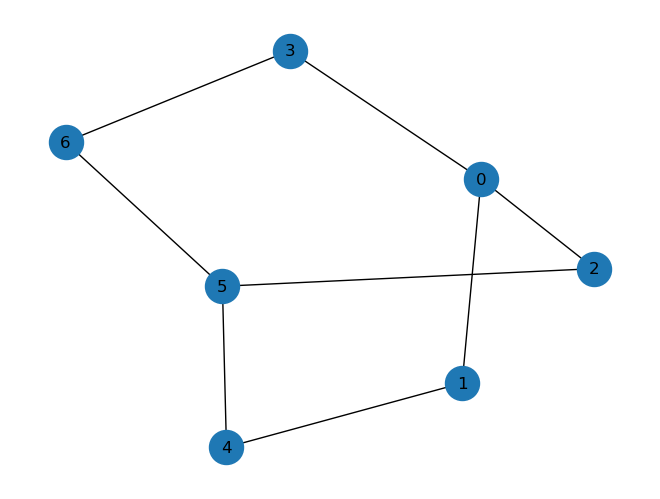

In [1393]:
graph = rx.PyGraph()
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
graph.add_edges_from([(i, j, 1) for (i, j) in edges])
draw_graph(graph, node_size=600, with_labels=True)


There is the core function in this example. I define function f with input gamma, beta. It then runs the quantum circuit with these parametrs. In the end, it counts the mean value for best $checkin solutions and returns the mean value. Function minimize tries to optimalize the parametrs to get solution as large as possible (it is minimize, so we need minus sign). To avoid stucking in local minima, we run it multiple times with random starting parametrs.

In [1394]:
def f(params):
    gamma,beta = params
    q = QuantumRegister(n, 'q')
    c = ClassicalRegister(n, 'c')
    qc = QuantumCircuit(q, c)
    for i in range (n):
        qc.h(q[i])
    for i in range(depth):
        for (i, j) in edges:
            qc.rzz(2*gamma, q[i], q[j])
        for i in range (n):
            qc.rx(2*beta, q[i])
    for i in range (n):
        qc.measure(q[i], c[i])

    simulator = AerSimulator(shots=shots/10)
    job = simulator.run(qc)
    result = job.result()
    counts = result.get_counts()
    sorted_counts = sorted(counts.items(), key=lambda item: item[1], reverse=True)[0:checkin]
    exval = 0
    for j in (sorted_counts):
        count = j[1]
        bitstring = j[0]
        exval += exp_val(edges, bitstring, count)
    exval = exval / (shots/10)
    return -exval

result = []
for i in range(seeds):
    result.append(minimize(f, [random.random(), random.random()], method='COBYLA'))
best = min(result, key=lambda r: r["fun"])
print(best)


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.23
       x: [ 2.557e-01  1.359e+00]
    nfev: 29
   maxcv: 0.0


Now we design our circuit with best parametrs we were able to obtain.

Gamma: 0.25573140946379974, Beta: 1.3590600857294464


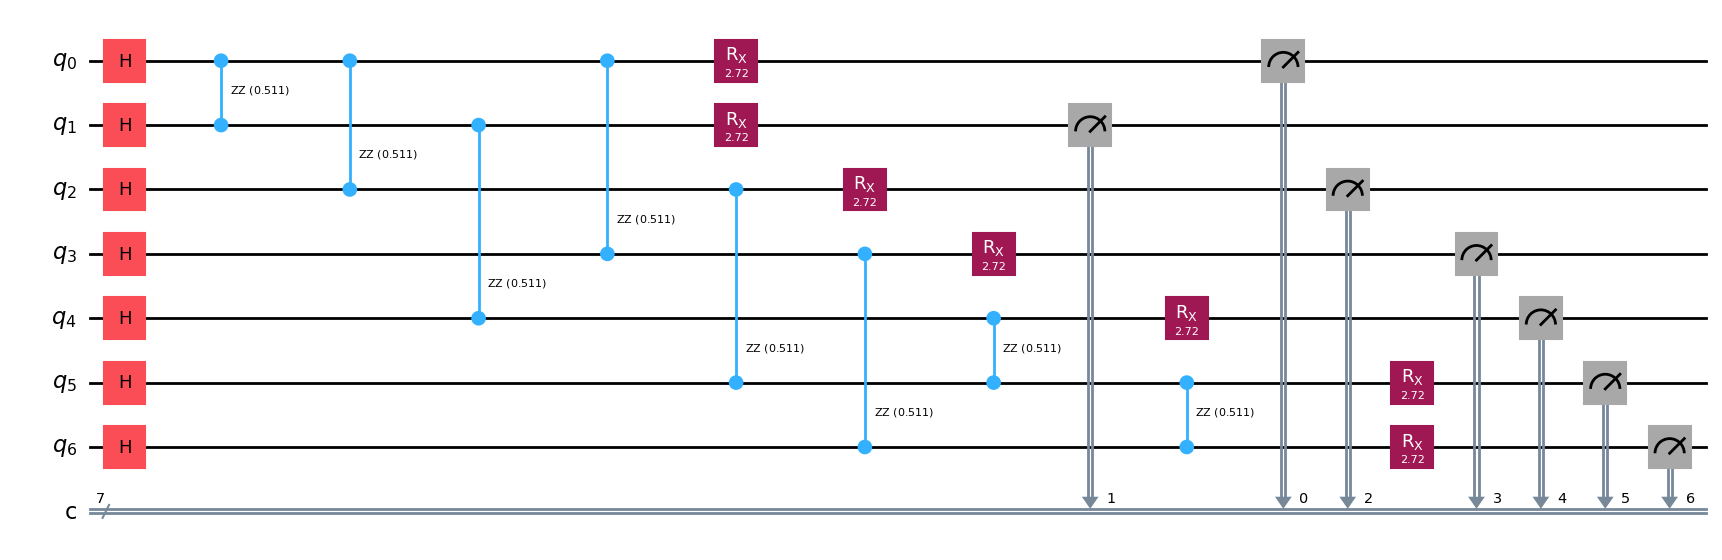

In [1395]:

q = QuantumRegister(n, 'q')
c = ClassicalRegister(n, 'c')
qc = QuantumCircuit(q, c)
for i in range (n):
    qc.h(q[i])
for k in range(depth):
    gamma, beta = best["x"]
    for (i, j) in edges:
        qc.rzz(2*gamma, q[i], q[j])
    for i in range (n):
        qc.rx(2*beta, q[i])
for i in range (n):
    qc.measure(q[i], c[i])
print("Gamma: " + str(gamma) + ", Beta: " + str(beta))
qc.draw("mpl")

There we run it.

In [1396]:
simulator = AerSimulator(shots=shots)
job = simulator.run(qc)
result = job.result()
counts = result.get_counts()

Now we print the most probable solutions + we check best $checkin solutions (by brute force) to find the truly best solution.

{'1011100': 29, '0100110': 8, '0111010': 11, '0111001': 26, '1001001': 6, '0111000': 8, '0100100': 3, '0111100': 15, '0001101': 4, '1011001': 15, '0010101': 15, '1010110': 15, '0101110': 28, '0110010': 4, '1000011': 14, '0010111': 6, '1101010': 10, '0010100': 7, '1011000': 5, '0111011': 3, '0100101': 7, '0001110': 19, '0000110': 3, '0110001': 13, '0101111': 5, '1000111': 18, '0101010': 32, '0110110': 7, '1010001': 29, '1100010': 16, '0101001': 18, '0011110': 25, '1101101': 5, '0010001': 8, '0101100': 10, '0110100': 6, '0001100': 4, '1110000': 3, '1001110': 19, '0111101': 5, '0100011': 23, '1010011': 12, '1000110': 29, '1111100': 2, '1010101': 30, '0011001': 7, '0011111': 4, '1100011': 19, '1011110': 15, '0110011': 7, '0101101': 8, '1100111': 4, '1010100': 21, '0001010': 3, '0001011': 7, '1001101': 1, '1110001': 18, '0100010': 5, '0111110': 7, '1110011': 2, '1001111': 2, '1011101': 11, '0110101': 5, '0101011': 12, '1100101': 7, '0011101': 17, '1100001': 15, '1011111': 3, '0110000': 2, '

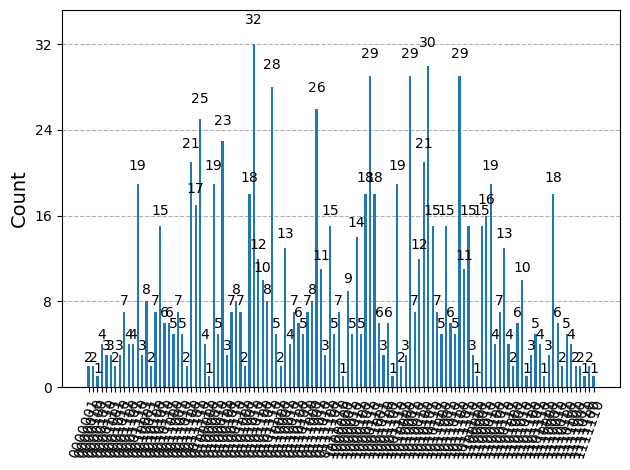

In [1397]:
print(counts)
sorted_counts = sorted(counts.items(), key=lambda item: item[1], reverse=True)[0:checkin]
print (sorted_counts)
best_count = min(sorted_counts, key=lambda r: -max_cut_value(edges, r[0]))
print("Most probable cut is " + str(max_cut_value(edges, sorted_counts[0][0])) + " edges")
print("Second probable cut is " + str(max_cut_value(edges, sorted_counts[1][0])) + " edges")
print("Third probable cut is " + str(max_cut_value(edges, sorted_counts[2][0])) + " edges")

print("Best cut found (in top "+ str(checkin) +") is " + str(max_cut_value(edges, best_count[0])) + " edges. (Probability: " + str(100*best_count[1]/shots) + "%)")
plot_histogram(counts)



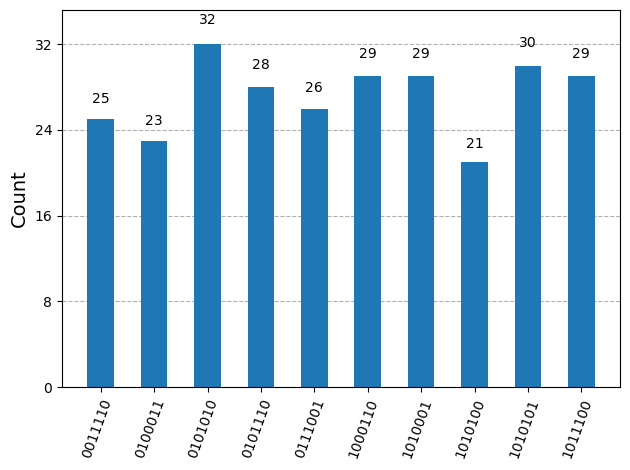

In [1398]:
counts_dict = dict(sorted_counts)
plot_histogram(counts_dict)

Best found bitstring: 0101010


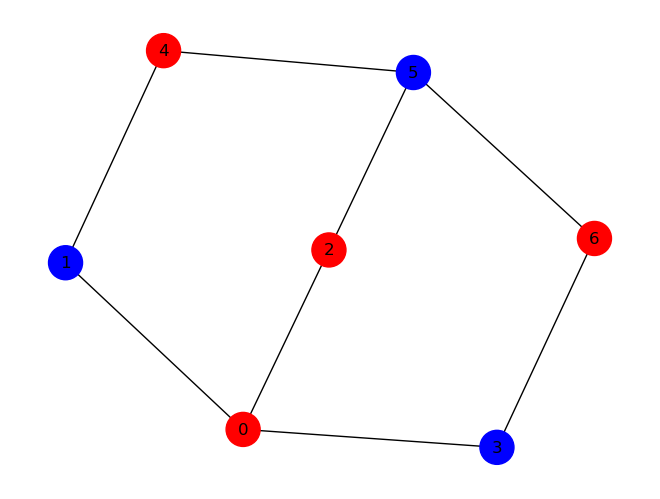

In [1399]:
graph = rx.PyGraph()
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
graph.add_edges_from([(i, j, 1) for (i, j) in edges])
group1 = []
group2 = []
max = best_count[0]
for i in range(len(max)):
    if max[i] == "0":
        group1.append(i)
    else:
        group2.append(i)

node_colors = ['red' if node in group1 else 'blue' for node in range(n)]

print("Best found bitstring: " + max)

# vykreslení grafu
draw_graph(graph, node_size=600, with_labels=True, node_color=node_colors)